# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [9]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

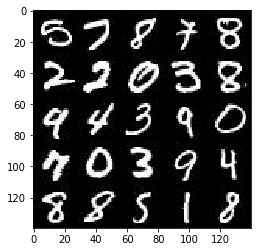

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

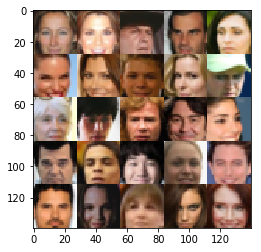

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [13]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [39]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    keep_prob = 0.9
    
    with tf.variable_scope('discriminator', reuse = reuse):
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        # h1 = tf.layers.batch_normalization(h1, training = True)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training = True)
        h2 = tf.maximum(alpha * h2, h2)
        # h2 = tf.nn.dropout(h2, keep_prob = keep_prob)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training = True)
        h3 = tf.maximum(alpha * h3, h3)
        # h3 = tf.nn.dropout(h3, keep_prob = keep_prob)
        
        # h4 = tf.layers.conv2d(h3, 512, 5, 1, 'same')
        # h4 = tf.layers.batch_normalization(h4, training = True)
        # h4 = tf.maximum(alpha * h4, h4)
        # h4 = tf.nn.dropout(h4, keep_prob = keep_prob)
        
        # For Three Layers
        flatten = tf.reshape(h3, (-1, 4 * 4 * 256))
        
        # For Four Layers
        # flatten = tf.reshape(h4, (-1, 7 * 7 * 512))
        
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)        

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [40]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        h1 = tf.layers.dense(z, 2 * 2 * 512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training = is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training = is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # h2 = tf.nn.dropout(h2, keep_prob = keep_prob)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training = is_train)
        h3 = tf.maximum(alpha * h3, h3)
        # h3 = tf.nn.dropout(h3, keep_prob = keep_prob)
        
        # h4 = tf.layers.conv2d_transpose(h3, 64, 3, 2, 'same')
        # h4 = tf.layers.batch_normalization(h4, training = is_train)
        # h4 = tf.maximum(alpha * h4, h4)
        # h4 = tf.nn.dropout(h4, keep_prob = keep_prob)
        
        # For Three Layers
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')        
        # For Four Layers
        # logits = tf.layers.conv2d_transpose(h4, out_channel_dim, 3, 2, 'same')
        
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [41]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                                            labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                            labels = tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                        labels = tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [56]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    with tf.control_dependencies([opt for opt in tf.get_collection(tf.GraphKeys.UPDATE_OPS) if opt.name.startswith('generator')]):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [68]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    l, w, h, c = data_shape
    input_real, input_z, lr = model_inputs(w, h, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    loss = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.
                
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_z: batch_z, lr: learning_rate})
            
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
            
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g)) 
                    loss.append((train_loss_d, train_loss_g))
                    # show_generator_output(sess, 1, input_z, c, data_image_mode)
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, c, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.3437
Epoch 1/2... Discriminator Loss: 0.4733... Generator Loss: 1.0438
Epoch 1/2... Discriminator Loss: 0.1443... Generator Loss: 7.0594
Epoch 1/2... Discriminator Loss: 0.0269... Generator Loss: 6.4263
Epoch 1/2... Discriminator Loss: 1.7453... Generator Loss: 4.9312
Epoch 1/2... Discriminator Loss: 1.6821... Generator Loss: 0.5268
Epoch 1/2... Discriminator Loss: 0.3144... Generator Loss: 2.0624
Epoch 1/2... Discriminator Loss: 0.3886... Generator Loss: 2.4075
Epoch 1/2... Discriminator Loss: 0.9495... Generator Loss: 8.4440
Epoch 1/2... Discriminator Loss: 0.4194... Generator Loss: 5.4923


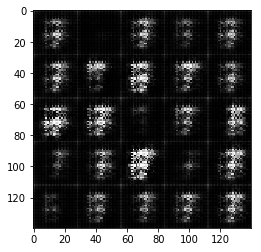

Epoch 1/2... Discriminator Loss: 0.2149... Generator Loss: 2.1568
Epoch 1/2... Discriminator Loss: 0.2333... Generator Loss: 3.1884
Epoch 1/2... Discriminator Loss: 0.1443... Generator Loss: 3.3960
Epoch 1/2... Discriminator Loss: 0.0695... Generator Loss: 3.3362
Epoch 1/2... Discriminator Loss: 0.4752... Generator Loss: 1.6312
Epoch 1/2... Discriminator Loss: 0.0948... Generator Loss: 3.8254
Epoch 1/2... Discriminator Loss: 0.3273... Generator Loss: 4.2204
Epoch 1/2... Discriminator Loss: 0.3372... Generator Loss: 5.9206
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.7294
Epoch 1/2... Discriminator Loss: 0.2149... Generator Loss: 2.8037


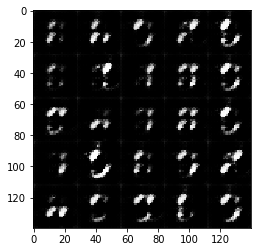

Epoch 1/2... Discriminator Loss: 0.1425... Generator Loss: 3.0501
Epoch 1/2... Discriminator Loss: 0.1792... Generator Loss: 4.9612
Epoch 1/2... Discriminator Loss: 0.0710... Generator Loss: 3.4632
Epoch 1/2... Discriminator Loss: 0.7471... Generator Loss: 1.7107
Epoch 1/2... Discriminator Loss: 0.7208... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 0.3786... Generator Loss: 1.6932
Epoch 1/2... Discriminator Loss: 0.2379... Generator Loss: 2.7892
Epoch 1/2... Discriminator Loss: 0.6767... Generator Loss: 7.4444
Epoch 1/2... Discriminator Loss: 0.3245... Generator Loss: 3.9325
Epoch 1/2... Discriminator Loss: 0.1474... Generator Loss: 4.4030


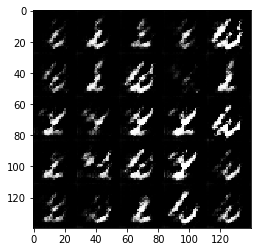

Epoch 1/2... Discriminator Loss: 0.1972... Generator Loss: 5.8358
Epoch 1/2... Discriminator Loss: 0.2874... Generator Loss: 2.9990
Epoch 1/2... Discriminator Loss: 0.6992... Generator Loss: 1.1495
Epoch 1/2... Discriminator Loss: 0.3623... Generator Loss: 2.3994
Epoch 1/2... Discriminator Loss: 0.2664... Generator Loss: 2.5703
Epoch 1/2... Discriminator Loss: 0.4433... Generator Loss: 1.6070
Epoch 1/2... Discriminator Loss: 0.1698... Generator Loss: 4.5613
Epoch 1/2... Discriminator Loss: 0.2998... Generator Loss: 3.8181
Epoch 1/2... Discriminator Loss: 0.5212... Generator Loss: 1.7493
Epoch 1/2... Discriminator Loss: 0.4070... Generator Loss: 2.5508


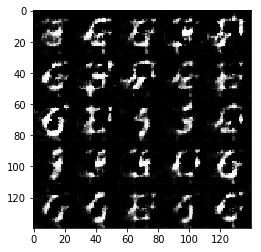

Epoch 1/2... Discriminator Loss: 0.7358... Generator Loss: 1.6124
Epoch 1/2... Discriminator Loss: 0.3483... Generator Loss: 2.3339
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 5.7410
Epoch 1/2... Discriminator Loss: 0.6778... Generator Loss: 1.3941
Epoch 1/2... Discriminator Loss: 1.8751... Generator Loss: 6.0723
Epoch 1/2... Discriminator Loss: 0.7898... Generator Loss: 1.1576
Epoch 1/2... Discriminator Loss: 0.2896... Generator Loss: 2.9313
Epoch 1/2... Discriminator Loss: 0.6637... Generator Loss: 3.6044
Epoch 1/2... Discriminator Loss: 0.7282... Generator Loss: 3.7198
Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 1.0353


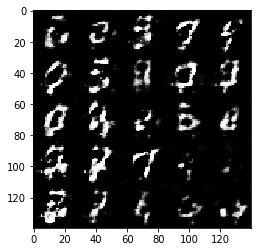

Epoch 1/2... Discriminator Loss: 0.5204... Generator Loss: 2.3949
Epoch 1/2... Discriminator Loss: 0.5464... Generator Loss: 1.7538
Epoch 1/2... Discriminator Loss: 0.7045... Generator Loss: 3.0894
Epoch 1/2... Discriminator Loss: 0.6150... Generator Loss: 2.0235
Epoch 1/2... Discriminator Loss: 0.5210... Generator Loss: 2.9487
Epoch 1/2... Discriminator Loss: 0.7009... Generator Loss: 1.7193
Epoch 1/2... Discriminator Loss: 0.6080... Generator Loss: 1.4077
Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 0.8604
Epoch 1/2... Discriminator Loss: 0.5548... Generator Loss: 1.3925
Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 0.5749


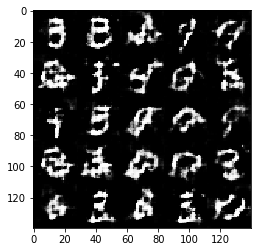

Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 1.0991
Epoch 1/2... Discriminator Loss: 0.7173... Generator Loss: 2.1805
Epoch 1/2... Discriminator Loss: 0.7231... Generator Loss: 1.0719
Epoch 1/2... Discriminator Loss: 0.8077... Generator Loss: 2.3265
Epoch 1/2... Discriminator Loss: 1.0958... Generator Loss: 3.3129
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.0318
Epoch 1/2... Discriminator Loss: 0.7568... Generator Loss: 1.7571
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 0.6685... Generator Loss: 2.0666
Epoch 1/2... Discriminator Loss: 0.5893... Generator Loss: 2.4655


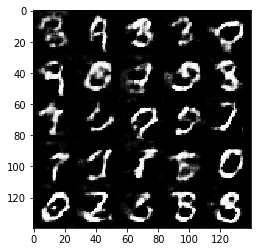

Epoch 1/2... Discriminator Loss: 0.6981... Generator Loss: 1.8043
Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 1.9328
Epoch 1/2... Discriminator Loss: 0.6717... Generator Loss: 2.1267
Epoch 1/2... Discriminator Loss: 0.6827... Generator Loss: 1.4925
Epoch 1/2... Discriminator Loss: 0.7444... Generator Loss: 2.4276
Epoch 1/2... Discriminator Loss: 0.5854... Generator Loss: 1.5797
Epoch 1/2... Discriminator Loss: 0.6572... Generator Loss: 1.3192
Epoch 1/2... Discriminator Loss: 0.5716... Generator Loss: 2.2930
Epoch 1/2... Discriminator Loss: 0.8239... Generator Loss: 0.9462
Epoch 1/2... Discriminator Loss: 1.0963... Generator Loss: 3.0354


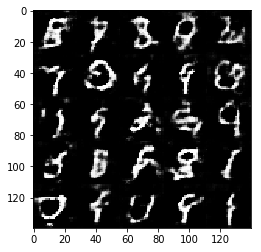

Epoch 1/2... Discriminator Loss: 0.5474... Generator Loss: 1.6736
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 2.4601
Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 1.6336
Epoch 1/2... Discriminator Loss: 0.6206... Generator Loss: 1.1759
Epoch 1/2... Discriminator Loss: 0.5396... Generator Loss: 1.6707
Epoch 1/2... Discriminator Loss: 0.6491... Generator Loss: 1.5200
Epoch 1/2... Discriminator Loss: 0.6919... Generator Loss: 2.7574
Epoch 1/2... Discriminator Loss: 0.7251... Generator Loss: 1.7087
Epoch 1/2... Discriminator Loss: 0.9582... Generator Loss: 2.5067
Epoch 1/2... Discriminator Loss: 1.1163... Generator Loss: 0.5870


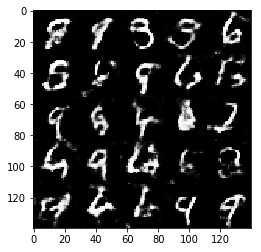

Epoch 1/2... Discriminator Loss: 0.6385... Generator Loss: 1.3022
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 3.7226
Epoch 1/2... Discriminator Loss: 0.7088... Generator Loss: 1.9196
Epoch 2/2... Discriminator Loss: 0.6089... Generator Loss: 1.5385
Epoch 2/2... Discriminator Loss: 1.5010... Generator Loss: 0.4250
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 0.8807... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 1.0525
Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 2.8454
Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.9436


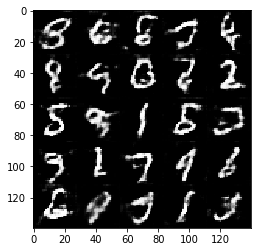

Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 1.7624
Epoch 2/2... Discriminator Loss: 0.6467... Generator Loss: 1.3324
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 0.5391
Epoch 2/2... Discriminator Loss: 0.7596... Generator Loss: 1.0154
Epoch 2/2... Discriminator Loss: 0.6304... Generator Loss: 2.0640
Epoch 2/2... Discriminator Loss: 0.6902... Generator Loss: 1.9833
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 1.1015
Epoch 2/2... Discriminator Loss: 0.8283... Generator Loss: 1.1720
Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 1.4458
Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 1.9615


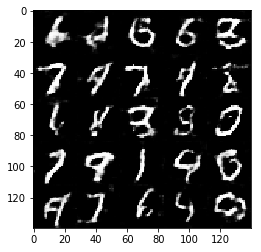

Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 1.0045
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 1.1677
Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 2.3014
Epoch 2/2... Discriminator Loss: 0.7280... Generator Loss: 1.1356
Epoch 2/2... Discriminator Loss: 0.6810... Generator Loss: 1.0640
Epoch 2/2... Discriminator Loss: 0.6287... Generator Loss: 1.8537
Epoch 2/2... Discriminator Loss: 1.2094... Generator Loss: 0.5359
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 0.7254
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 0.8510
Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 2.6765


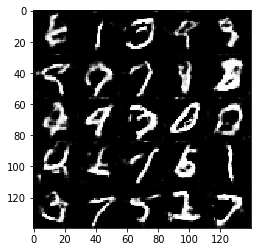

Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 1.2514
Epoch 2/2... Discriminator Loss: 0.6060... Generator Loss: 1.0672
Epoch 2/2... Discriminator Loss: 2.1837... Generator Loss: 0.2159
Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 0.9237
Epoch 2/2... Discriminator Loss: 0.6142... Generator Loss: 1.0299
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.0031
Epoch 2/2... Discriminator Loss: 0.6063... Generator Loss: 1.2164
Epoch 2/2... Discriminator Loss: 0.5616... Generator Loss: 1.5850
Epoch 2/2... Discriminator Loss: 0.7138... Generator Loss: 0.9527
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 2.1415


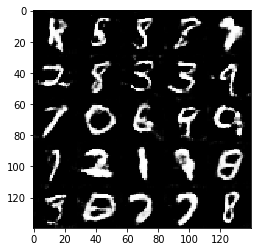

Epoch 2/2... Discriminator Loss: 0.7820... Generator Loss: 1.3086
Epoch 2/2... Discriminator Loss: 0.8328... Generator Loss: 0.8565
Epoch 2/2... Discriminator Loss: 0.9559... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 0.7304... Generator Loss: 1.1770
Epoch 2/2... Discriminator Loss: 1.1154... Generator Loss: 0.5837
Epoch 2/2... Discriminator Loss: 0.5960... Generator Loss: 1.4824
Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 1.3741
Epoch 2/2... Discriminator Loss: 0.6459... Generator Loss: 1.0130
Epoch 2/2... Discriminator Loss: 0.6080... Generator Loss: 1.7900
Epoch 2/2... Discriminator Loss: 0.7253... Generator Loss: 1.0691


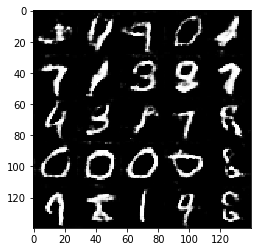

Epoch 2/2... Discriminator Loss: 1.4760... Generator Loss: 0.3814
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 2.0065
Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.4961
Epoch 2/2... Discriminator Loss: 0.8553... Generator Loss: 1.2013
Epoch 2/2... Discriminator Loss: 0.7774... Generator Loss: 1.1936
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 0.9604
Epoch 2/2... Discriminator Loss: 0.6902... Generator Loss: 2.1087
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 0.4599
Epoch 2/2... Discriminator Loss: 0.8011... Generator Loss: 1.2861
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 0.7773


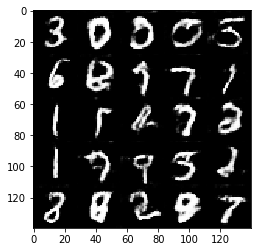

Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.4103
Epoch 2/2... Discriminator Loss: 0.6863... Generator Loss: 2.0623
Epoch 2/2... Discriminator Loss: 0.6185... Generator Loss: 1.6536
Epoch 2/2... Discriminator Loss: 0.7753... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.0035... Generator Loss: 0.6470
Epoch 2/2... Discriminator Loss: 0.7337... Generator Loss: 1.4098
Epoch 2/2... Discriminator Loss: 1.4957... Generator Loss: 0.4086
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 1.1387
Epoch 2/2... Discriminator Loss: 1.3895... Generator Loss: 0.4809
Epoch 2/2... Discriminator Loss: 1.6355... Generator Loss: 0.3171


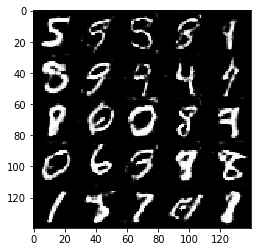

Epoch 2/2... Discriminator Loss: 0.8013... Generator Loss: 0.8631
Epoch 2/2... Discriminator Loss: 0.6289... Generator Loss: 1.7931
Epoch 2/2... Discriminator Loss: 0.9527... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 0.4999... Generator Loss: 1.8431
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 2.5105
Epoch 2/2... Discriminator Loss: 1.1957... Generator Loss: 0.5135
Epoch 2/2... Discriminator Loss: 0.7481... Generator Loss: 0.9562
Epoch 2/2... Discriminator Loss: 0.7285... Generator Loss: 0.9043
Epoch 2/2... Discriminator Loss: 0.8932... Generator Loss: 0.7953
Epoch 2/2... Discriminator Loss: 1.4352... Generator Loss: 0.5994


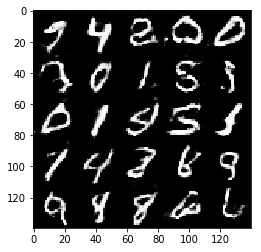

Epoch 2/2... Discriminator Loss: 0.6737... Generator Loss: 1.4556
Epoch 2/2... Discriminator Loss: 0.6076... Generator Loss: 1.8499
Epoch 2/2... Discriminator Loss: 0.7156... Generator Loss: 1.9147
Epoch 2/2... Discriminator Loss: 0.8625... Generator Loss: 0.8778
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 0.8281
Epoch 2/2... Discriminator Loss: 0.6530... Generator Loss: 2.3498
Epoch 2/2... Discriminator Loss: 0.6621... Generator Loss: 1.5700
Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 1.1886
Epoch 2/2... Discriminator Loss: 0.5507... Generator Loss: 1.4583
Epoch 2/2... Discriminator Loss: 0.6565... Generator Loss: 1.5135


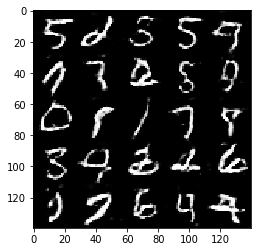

Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 0.6267
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 0.4598
Epoch 2/2... Discriminator Loss: 1.9146... Generator Loss: 4.6448
Epoch 2/2... Discriminator Loss: 0.6823... Generator Loss: 1.1399
Epoch 2/2... Discriminator Loss: 1.2874... Generator Loss: 0.4911
Epoch 2/2... Discriminator Loss: 1.0481... Generator Loss: 0.8834
Epoch 2/2... Discriminator Loss: 0.7820... Generator Loss: 0.9141


In [69]:
batch_size = 64
z_dim = 100
learning_rate = .0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 9.0409
Epoch 1/1... Discriminator Loss: 0.1571... Generator Loss: 13.9188
Epoch 1/1... Discriminator Loss: 0.4293... Generator Loss: 20.4320
Epoch 1/1... Discriminator Loss: 0.0353... Generator Loss: 6.2387
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 19.7540
Epoch 1/1... Discriminator Loss: 0.0865... Generator Loss: 8.7904
Epoch 1/1... Discriminator Loss: 1.7813... Generator Loss: 14.8785
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 6.7716
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.3386
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 1.0286


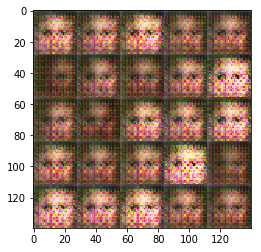

Epoch 1/1... Discriminator Loss: 0.3098... Generator Loss: 7.1779
Epoch 1/1... Discriminator Loss: 0.2783... Generator Loss: 1.9425
Epoch 1/1... Discriminator Loss: 0.1613... Generator Loss: 2.8296
Epoch 1/1... Discriminator Loss: 0.3566... Generator Loss: 3.2647
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 2.0841... Generator Loss: 0.1738
Epoch 1/1... Discriminator Loss: 1.6714... Generator Loss: 0.2575
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 1.7756
Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 1.4306
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.4837


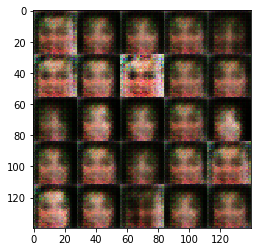

Epoch 1/1... Discriminator Loss: 2.2299... Generator Loss: 0.2125
Epoch 1/1... Discriminator Loss: 1.6851... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 1.9667
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.1945
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.3259
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.0902


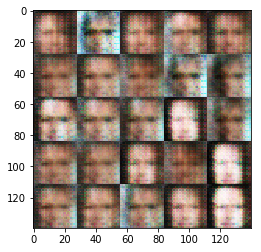

Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 2.9617
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 0.5891... Generator Loss: 1.6606
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.5002


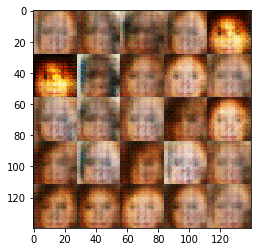

Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 1.3805
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 2.4150
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 2.7303
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 1.5444
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.8757


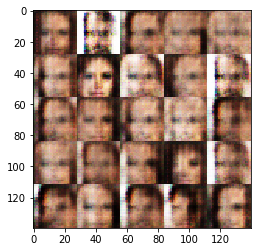

Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 1.6963
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.5796
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 3.1704... Generator Loss: 0.0761
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.0386


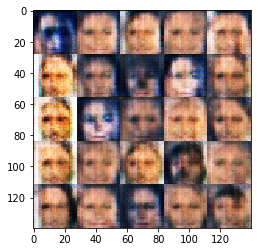

Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.4847
Epoch 1/1... Discriminator Loss: 0.6465... Generator Loss: 1.3408
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.5609
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.1843
Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 1.3265


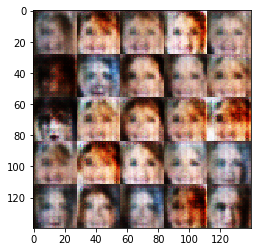

Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 1.1255
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 2.0377


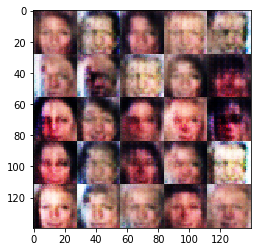

Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.2775
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.3313
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.2396
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 2.3244
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 1.3718
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 1.0802


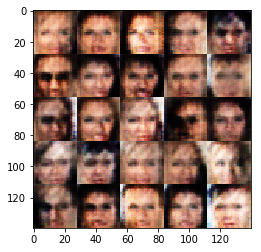

Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 2.3840
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.5753
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.4858
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.2289
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.9462
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.6431


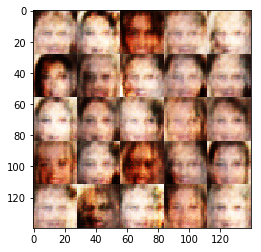

Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.3535
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.4813
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.7458... Generator Loss: 0.3501
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.0874


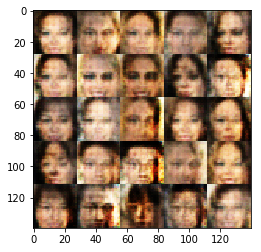

Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.6815
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.2898
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.8725


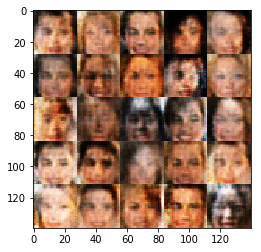

Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 2.0724
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.7955
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.3508
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 1.9603
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 1.2255


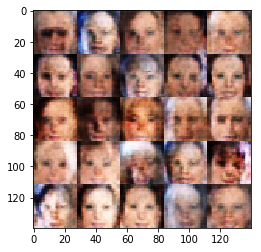

Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 1.2878
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.4718
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.0792


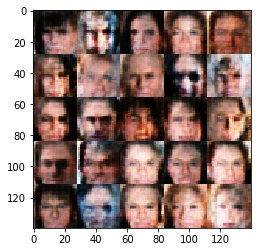

Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.3770
Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 1.6092
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 0.8926


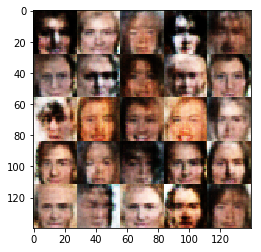

Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 2.4210
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.8714
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.9151
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 2.1745
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.3512


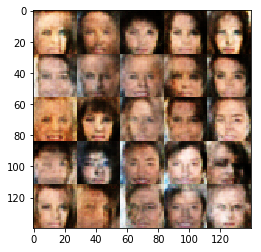

Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.3461
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.5239
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.4578
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.4309
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 0.6748... Generator Loss: 1.8935


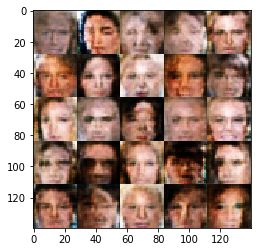

Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.7148... Generator Loss: 0.3327
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.4198
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.5646
Epoch 1/1... Discriminator Loss: 0.8221... Generator Loss: 1.2004
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 2.4277
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.0431


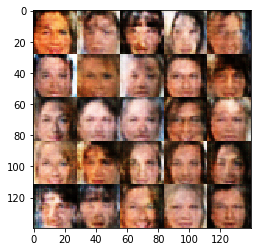

Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.7458
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 2.0097
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.7152
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.3407
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 1.3927


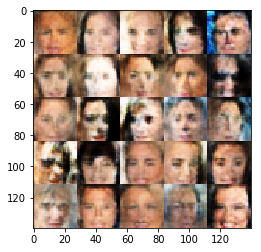

Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.3257
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.8303
Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 1.2023
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.4359
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.5548


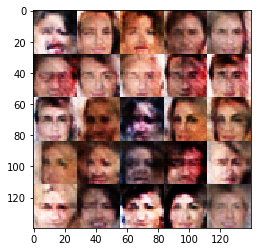

Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.5846
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.2383
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 1.7593
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 1.7641


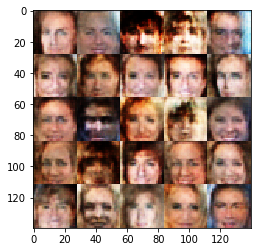

Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 2.7264
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 0.8628... Generator Loss: 1.6203
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 2.1144


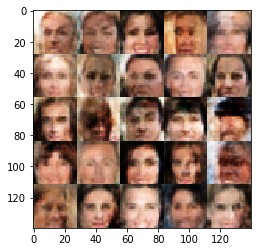

Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.2763
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.6014
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.0889


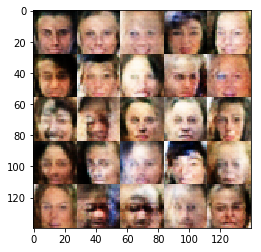

Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.5630
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 0.7037


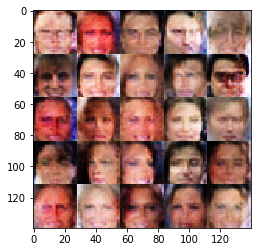

Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.4409
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.7136
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 1.5243


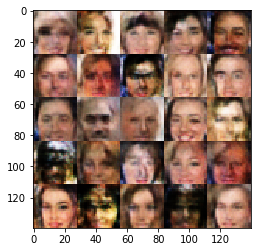

Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 1.9049
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 0.6653... Generator Loss: 1.3958


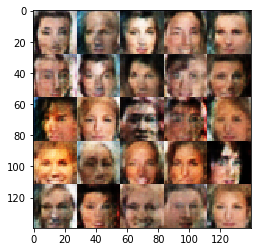

Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.9030
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.6769
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 0.5934... Generator Loss: 1.7766
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.6163
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 1.6565... Generator Loss: 0.3101


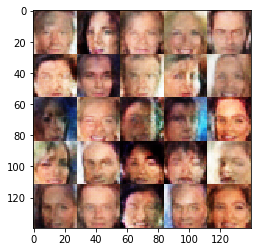

Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.7733
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 1.7892
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 2.3821
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 2.1769
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.6622
Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 1.7633


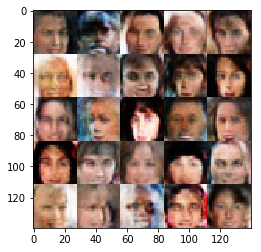

Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.2607
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.3029
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 3.4587
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 0.9782... Generator Loss: 1.3280
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.5314


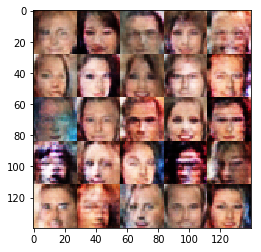

Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.4189
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 1.7109
Epoch 1/1... Discriminator Loss: 0.7276... Generator Loss: 1.5454
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.4126


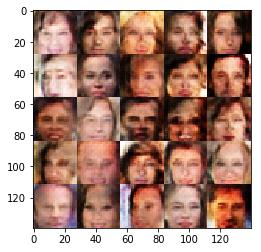

Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 2.4949
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.5566
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.9002
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.7649
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.1220


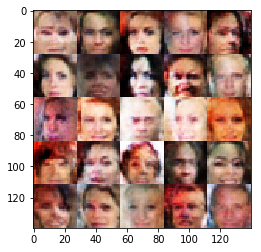

Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 2.8681
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 1.3107
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.3193


In [70]:
batch_size = 64
z_dim = 100
learning_rate = .0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.